### 要求

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 加载数据文件

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
   s = s.lower().strip()
   if ' ' not in s:
       s = list(s)
       s = ' '.join(s)
   s = unicodeToAscii(s)
   s = re.sub(r"([.!?])", r" \1", s)
   return s

In [5]:
def readLangs(lang1, lang2, reverse=True):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('cmn.txt', encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=True):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

### 测试加载

In [8]:
input_lang, output_lang, pairs = prepareData('eng', 'cmn', True)
print(random.choice(pairs))

Reading lines...
Read 23610 sentence pairs
Trimmed to 449 sentence pairs
Counting words...
Counted words:
cmn 676
eng 549
['他 是 教 师 。', 'he is a teacher .']


### 编码器

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 解码器

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 注意力机制的解码器

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### 准备训练数据

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### 训练模型

In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

### 辅助功能

In [14]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### 训练

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    plt.plot(plot_losses, color="b", label="loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    return(plot_losses)

### 结果可视化

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

### 评估

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [18]:
from nltk.translate.bleu_score import sentence_bleu

def evaluateRandomly(encoder, decoder, n=100):
    tot_bleu_score = 0
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        words = pair[1].strip(' ').split(' ')
        kk = []
        words.append('<EOS>')
        kk.append(words)
        bleu_score = sentence_bleu(kk, output_words)
        tot_bleu_score += bleu_score
        print("bleu score = ", bleu_score)
        print('')
    print("average bleu score = ", tot_bleu_score/n)

2m 14s (- 31m 18s) (5000 6%) 2.2098
4m 36s (- 29m 56s) (10000 13%) 0.5086
6m 55s (- 27m 40s) (15000 20%) 0.0739
9m 13s (- 25m 21s) (20000 26%) 0.0484
11m 32s (- 23m 4s) (25000 33%) 0.0432
13m 53s (- 20m 50s) (30000 40%) 0.0411
16m 19s (- 18m 39s) (35000 46%) 0.0341
18m 46s (- 16m 25s) (40000 53%) 0.0335
21m 7s (- 14m 5s) (45000 60%) 0.0349
23m 25s (- 11m 42s) (50000 66%) 0.0310
25m 46s (- 9m 22s) (55000 73%) 0.0344
28m 6s (- 7m 1s) (60000 80%) 0.0290
30m 30s (- 4m 41s) (65000 86%) 0.0306
32m 57s (- 2m 21s) (70000 93%) 0.0281
35m 44s (- 0m 0s) (75000 100%) 0.0311


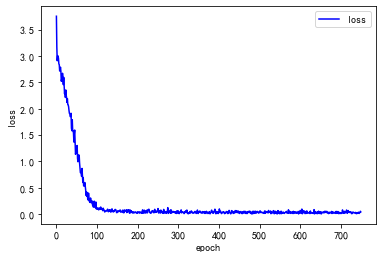

In [72]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

plot_losses = trainIters(encoder1, attn_decoder1, 75000, print_every=5000)


### 保存模型

In [73]:
from joblib import dump
dump(encoder1, "encoder1.txt")  
dump(attn_decoder1, "attn_decoder1.txt")

['attn_decoder1.txt']

### 加载模型

In [19]:
from joblib import load
encoder1 = load("encoder1.txt")
attn_decoder1 = load("attn_decoder1.txt")

In [20]:
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [70]:
evaluateRandomly(encoder1, attn_decoder1)

> 他 是 教 师 。
= he is a teacher .
< he is a teacher . <EOS>
bleu score =  1.0

> 我 对 运 动 感 兴 趣 。
= i am interested in sports .
< i am interested in sports . <EOS>
bleu score =  1.0

> 我 是 个 学 生 。
= i am a student .
< i am a student . <EOS>
bleu score =  1.0

> 他 正 在 散 步 。
= he is taking a walk .
< he is taking a walk . <EOS>
bleu score =  1.0

> 你 擋 住 了 我 的 路 。
= you are in my way .
< you are in my way . <EOS>
bleu score =  1.0

> 他 跟 我 過 不 去 。
= he is giving me a hard time .
< he is giving me a hard time . <EOS>
bleu score =  1.0

> 这 是 一 个 小 偷 。
= he is a thief .
< he is a thief . <EOS>
bleu score =  1.0

> 他 们 在 吃 午 饭 。
= they are at lunch .
< they are at lunch . <EOS>
bleu score =  1.0

> 我 是 一 个 好 男 孩 。
= i am a good boy .
< i am a good boy . <EOS>
bleu score =  1.0

> 她 是 個 很 棒 的 女 人 。
= she is a wonderful woman .
< she is a wonderful woman . <EOS>
bleu score =  1.0

> 她 下 週 要 去 法 國 。
= she is going to france next week .
< she is going to france next week . <EOS>
bleu score =  1.0


D:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


 he is careless about money . <EOS>
bleu score =  1.0

> 他 浑 身 是 债 。
= he is up to his ears in debt .
< he is up to his ears in debt . <EOS>
bleu score =  1.0

> 我 贊 成 你 的 建 議 。
= i am in favor of your proposal .
< i am in favor of your proposal . <EOS>
bleu score =  1.0

> 我 在 右 邊 。
= i am on the right .
< i am on the right . <EOS>
bleu score =  1.0

> 他 習 慣 早 起 。
= he is used to getting up early .
< he is used to getting up early . <EOS>
bleu score =  1.0

> 你 总 是 迟 到 。
= you are always late .
< you are always late . <EOS>
bleu score =  1.0

> 我 在 班 里 是 最 高 的 。
= i am the tallest in our class .
< i am the tallest in our class . <EOS>
bleu score =  1.0

> 我 来 自 葡 萄 牙 。
= i am from portugal .
< i am from portugal . <EOS>
bleu score =  1.0

> 我 在 祈 禱 。
= i am praying .
< i am praying . <EOS>
bleu score =  1.0

> 我 週 日 哪 裡 也 不 去 。
= i am not going anywhere on sunday .
< i am not going anywhere on sunday . <EOS>
bleu score =  1.0

> 我 不 是 正 在 寫 信 。
= i am not writing a letter .
< i am not

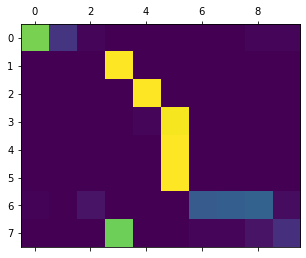

In [20]:
output_words, attentions = evaluate(encoder1, attn_decoder1, "他 依 旧 充 满 活 力 。")
plt.matshow(attentions.numpy())

In [22]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = 今 天 是 星 期 六 。
output = i am sixteen years old . <EOS>


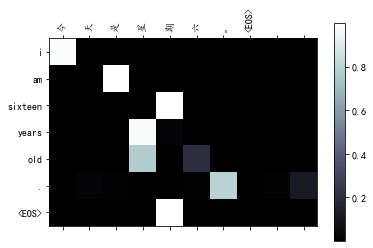

In [23]:
evaluateAndShowAttention("今 天 是 星 期 六 。")

input = 我 草 你 爸 爸 。
output = i am your father . <EOS>


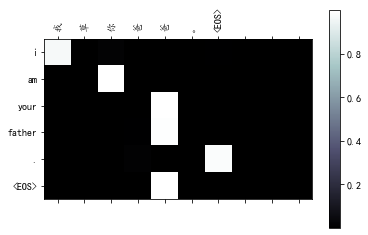

In [24]:
evaluateAndShowAttention("我 草 你 爸 爸 。")

input = 他 的 狗 死 了 。
output = he is afraid of death . <EOS>


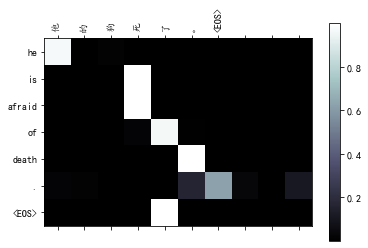

In [26]:
evaluateAndShowAttention("他 的 狗 死 了 。")